# Task1 (Matrix Version)

## 0. Adjustments
+ Choose ssd rather than sad : accuracy
+ Normalization before matching : accuracy
+ Only choose a part of image(ROI) to match
+ The size of window and step can be scaled based on the size of image

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

## 1. Choose ROI
+ We only use a part of image to match

In [2]:
# single channel img
# h_factor, w_factor: the start position of img, default (0.5,0.5)
# window: the size of window, default 40
# threshold: maximum moves, default 15
def get_roi(img, h_factor, w_factor, window, threshold, step):
    height, width = img.shape
    h_start = int(h_factor * height)
    h_end = h_start + threshold * step + window - 1
    w_start = int(w_factor * width)
    w_end = w_start + threshold * step + window - 1
    
    return img[h_start:h_end, w_start:w_end]

In [3]:
# test
img1 = cv2.imread('s1.jpg',0)
img1_roi = get_roi(img1, 0, 0, 3, 3, 1)
img1_roi.shape

(5, 5)

## 2. Available methods to compute similarity:
+ SAD is faster but sensitive to noise
+ SSD is more accurate but slower, for following steps we will use it

In [4]:
def sad(window1, window2):
    return np.sum(np.absolute(window1 - window2))
def ssd(window1, window2):
    return np.sum(np.power(window1 - window2, 2))

## 3. Get the combination of positions
+ e.g. [0,0,1,1] means img1[0,0] and img2[1,1]

In [5]:
# https://stackoverflow.com/questions/11144513/numpy-cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points
def cartesian(list_x, list_y):
    return np.transpose([np.tile(list_x, len(list_y)), np.repeat(list_y, len(list_x))])

In [6]:
# step: default 1, the length of one sliding step
def cartesian2D(list_x, list_y, step):
    xy_index = cartesian(range(0, len(list_x), step), range(0, len(list_y), step))
    
    # define a lambda function
    concat_positions = lambda pos : np.concatenate((list_x[pos[0]], list_y[pos[1]]))
    
    return np.apply_along_axis(concat_positions, 1, xy_index)

In [7]:
# test
list_x = np.arange(16).reshape((8,2))
list_y = np.arange(16).reshape((8,2))
cartesian2D(list_x, list_y, step = 3)

array([[ 0,  1,  0,  1],
       [ 6,  7,  0,  1],
       [12, 13,  0,  1],
       [ 0,  1,  6,  7],
       [ 6,  7,  6,  7],
       [12, 13,  6,  7],
       [ 0,  1, 12, 13],
       [ 6,  7, 12, 13],
       [12, 13, 12, 13]])

## 4. Look for best match

In [8]:
# img : single channel img roi after normalization
# window: the size of window, default 40
# step: step length
def get_best_match(img1, img2, window, step):    
    
    # get combinations of positions
    height, width = img1.shape
    num_window_h = max((height - window) / step,0) + 1
    num_window_w = max((width - window) / step,0) + 1
    img1_positions = cartesian(range(num_window_h), range(num_window_w))
    img2_positions = img1_positions.copy()
    combined_positions = cartesian2D(img1_positions, img2_positions, step)

    # define a lambda function: calculate_similarity
    # (pos[0],pos[1]) is the start position of window1, 
    calculate_similarity = lambda pos: ssd(img1[pos[0]:pos[0]+window,pos[1]:pos[1]+window], img2[pos[2]:pos[2]+window,pos[3]:pos[3]+window])

    # apply this function to combined_positions
    similarity = np.apply_along_axis(calculate_similarity, 1, combined_positions)
    
    # find the best match positions and similarity result
    smallest_index = np.argmin(similarity)
    img1_h, img1_w, img2_h, img2_w = combined_positions[smallest_index]
    
    return img1_h, img1_w, img2_h, img2_w, similarity[smallest_index]

In [9]:
# test
img1 = cv2.imread('s1.jpg',0)
img2 = cv2.imread('s2.jpg',0)
img1 = img1[100:300,100:300]
img2 = img2[100:300,100:300]

In [10]:
get_best_match(img1, img2, 150, 3)

(15, 0, 0, 9, 2280659)

## 5. Main function

In [11]:
# h_factor, w_factor: default (0.5, 0.5), the start position in the image
# window: default 40, the size of window
# threshold: default 15, the maximum moves
# step: default 1, the step length
def task1(img_name, h_factor, w_factor, window, threshold, step):
    
    start_time = time.clock()
    img = cv2.imread(img_name)
    height, width = img.shape[:2]
    
    # split the image
    sub_height = int(height / 3)
    blue = img[0:sub_height,:,0]
    green = img[sub_height:sub_height*2,:,1]
    red = img[sub_height*2:sub_height*3,:,2]
    
    # scale the parameters
    scale_factor = max(int(min(sub_height / 350, width / 400)), 1)
    window *= scale_factor
    step *= scale_factor
    
    # get roi
    blue_roi = get_roi(blue, h_factor, w_factor, window, threshold, step)
    green_roi = get_roi(green, h_factor, w_factor, window, threshold, step)
    red_roi = get_roi(red, h_factor, w_factor, window, threshold, step)
    
    # normalization
    normalized_blue = cv2.normalize(blue_roi, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_green = cv2.normalize(green_roi, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_red = cv2.normalize(red_roi, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # get best match of green based on blue
    rows, cols = blue.shape
    b_h, b_w, g_h, g_w, best_match = get_best_match(normalized_blue, normalized_green, window, step)
    print str([b_h, b_w, g_h, g_w])
    changed_green = cv2.warpAffine(green, np.float32([[1,0,b_w-g_w],[0,1,b_h-g_h]]), (cols, rows))
    
    # get best match of red based on blue
    b_h, b_w, r_h, r_w, best_match = get_best_match(normalized_blue, normalized_red, window, step)
    print str([b_h, b_w, r_h, r_w])
    changed_red = cv2.warpAffine(red, np.float32([[1,0,b_w-r_w],[0,1,b_h-r_h]]), (cols, rows))
    
    # merge the images
    merged_img = cv2.merge([blue, changed_green, changed_red])
    
    end_time = time.clock()
    print "Running time : " + str(end_time-start_time)

    return merged_img

## 7. Test

In [12]:
merged_img1 = task1("s1.jpg", 0.60, 0.40, 40, 12,1) 
merged_img2 = task1("s2.jpg", 0.50, 0.50, 40, 13,1) 
merged_img3 = task1("s3.jpg", 0.50, 0.75, 30, 15,1) 
merged_img4 = task1("s4.jpg", 0.50, 0.50, 30, 10,1) 
merged_img5 = task1("s5.jpg", 0.50, 0.50, 30, 10,1)

[6, 9, 0, 8]
[11, 1, 0, 0]
Running time : 3.015323
[5, 8, 0, 3]
[12, 8, 0, 0]
Running time : 4.061879
[14, 14, 7, 12]
[14, 14, 0, 12]
Running time : 5.68713
[1, 2, 0, 0]
[9, 4, 0, 1]
Running time : 1.137833
[7, 9, 9, 7]
[8, 9, 9, 6]
Running time : 1.140865


In [30]:
merged_img1 = cv2.cvtColor(merged_img1, cv2.COLOR_BGR2RGB)
merged_img2 = cv2.cvtColor(merged_img2, cv2.COLOR_BGR2RGB)
merged_img3 = cv2.cvtColor(merged_img3, cv2.COLOR_BGR2RGB)
merged_img4 = cv2.cvtColor(merged_img4, cv2.COLOR_BGR2RGB)
merged_img5 = cv2.cvtColor(merged_img5, cv2.COLOR_BGR2RGB)

In [31]:
plt.figure(figsize=(6, 30))
plt.subplot(511)
plt.imshow(merged_img1)
plt.subplot(512)
plt.imshow(merged_img2)
plt.subplot(513)
plt.imshow(merged_img3)
plt.subplot(514)
plt.imshow(merged_img4)
plt.subplot(515)
plt.imshow(merged_img5)

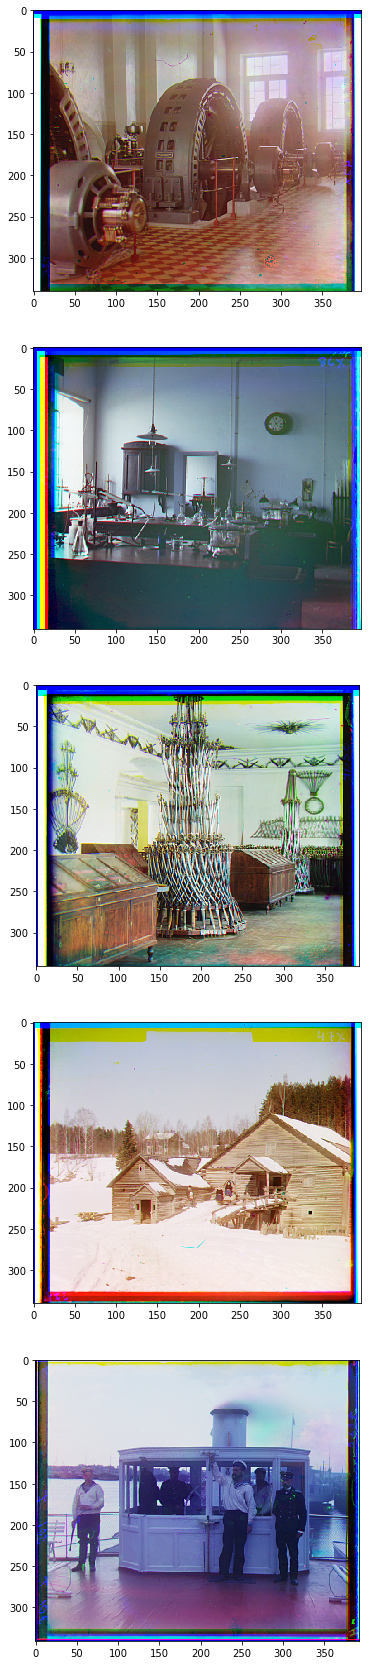

In [32]:
plt.show()

## Till now task 1 is finished